In [3]:
"""
We aim to maximize the click rate of two users on webarticles 
uisng contextual bandits using the vowpalwabbit framework
"""
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt
random.seed(7)## to ensure reproducibility

## Preprocessing ##
Firstly we model the cost for the actions of the users as negative of the reward. We also define functions for preprocessing and representing the data in VW compatible form. Further deatils of the problem defintion can be found [here](https://vowpalwabbit.org/tutorials/cb_simulation.html#second-scenario  "VW Tutorial")

In [4]:
"""
Modelling the reward as the negative of the cost 
"""
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

In [5]:
"""
We Define the cost function for the bandit instance 
"""
def get_cost(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [6]:
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]


In [7]:
"""
Example of Vowpal Wabbit format
"""
context = {"user":"Tom","time_of_day":"morning"}
actions = ["politics", "sports", "music", "food"]

print(to_vw_example_format(context,actions))

shared |User user=Tom time_of_day=morning
|Action article=politics 
|Action article=sports 
|Action article=music 
|Action article=food 


In [8]:
"""
Function to sample form the list of probabilities that VW provides as
output
--------
Output: Index that was sampled and the probability
"""
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [9]:
"""
This function chooses action for specific user and context
"""
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [10]:
"""
We Define the context for the contextual bandits 
We have 2 users Tom and Anna
"""

users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

In [11]:
"""
"""
def run_simulation(vw, num_iterations, users, times_of_day, actions, cost_function, do_learn = True):
    cost_sum = 0.
    ctr = []

    for i in range(1, num_iterations+1):
        # 1. In each simulation choose a user
        user = choose_user(users)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {'user': user, 'time_of_day': time_of_day}
        action, prob = get_action(vw, context, actions)

        # 4. Get cost of the action we chose
        cost = cost_function(context, action)
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
            # 6. Learn
            vw.learn(vw_format)
            # 7. Let VW know you're done with these objects
            vw.finish_example(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1*cost_sum/i)

    return ctr

In [12]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

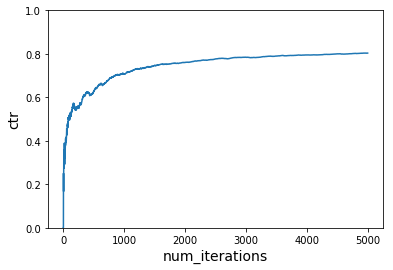

In [13]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)

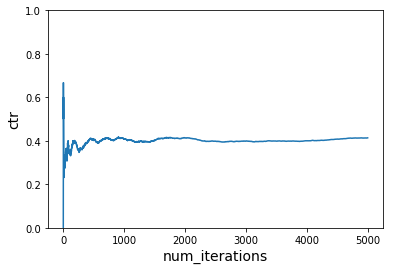

In [14]:
vw = pyvw.vw("--cb_explore_adf --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)

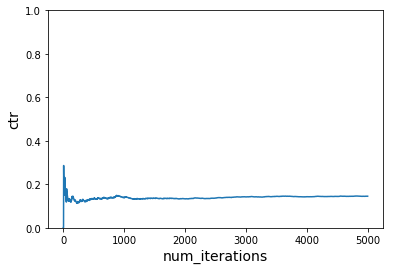

In [15]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost, do_learn=False)

plot_ctr(num_iterations, ctr)

In [16]:
def get_cost_new1(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [17]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

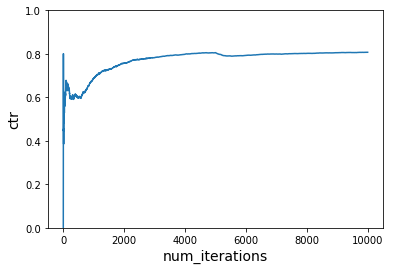

In [18]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

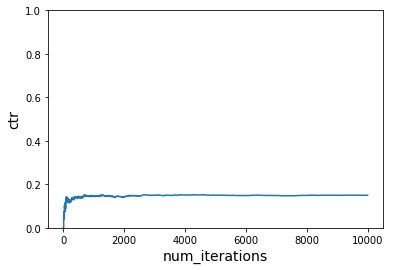

In [19]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)
plot_ctr(total_iterations, ctr)

# Experiments
## Adding New Cost Functions and varrying noise
We add 3 new cost functions for both Tom and Anna thus making the distribution vary over time
  ### Tom

|     |get_cost	|get_cost_new1|get_cost_new2|get_cost_new3|get_cost_new4|
|-----|-----|------|------|------|------|
| Morning  |Politics    |Politics     |Sports|Politics|Finance|
|Afternoon|Music     |Sports     |Sports|Politics|Politics|

  ### Anna

|     |get_cost	|get_cost_new1|get_cost_new2|get_cost_new3|get_cost_new4|
|-----|-----|------|------|------|------|
| Morning  |Sports    |Sports     |Politics|Sports|Sports|
|Afternoon|Politics     |Sports     |Sports|Food|Music|

#### We also add varying random noise to the reward distribution, the average magnitude and variance of the noise changes over time 


In [27]:
"""
Adding New cost functions
Noise is added by adding a random number between 0 and 0.25 to the cost when user likes the article
"""
def get_cost_new2(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'sport':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE+0.25*random.random()
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE+0.25*random.random()

In [28]:
def get_cost_new3(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE+0.5*random.random()
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'food':
            return USER_LIKED_ARTICLE+0.5*random.uniform(-1, 1)
        else:
            return USER_DISLIKED_ARTICLE

In [29]:
def get_cost_new4(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'finance':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE+0.55*random.uniform(-1, 1)
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE+0.55*random.uniform(-1, 1)
        else:
            return USER_DISLIKED_ARTICLE

epsilon greedy


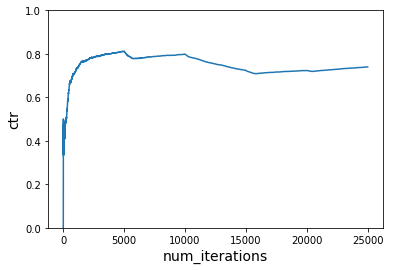

In [89]:
# Instantiate learner in VW
"""
Adding various cost functions so that reward function varies over 
the time
We have added 4 new cost functions
We have used epsilon greedy strategy in this experiment for exploration
"""
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1,get_cost_new2,get_cost_new3,get_cost_new4]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)
print('epsilon greedy')
plot_ctr(total_iterations, ctr)

## Trying various exploration algorithms

Bagging Explorer


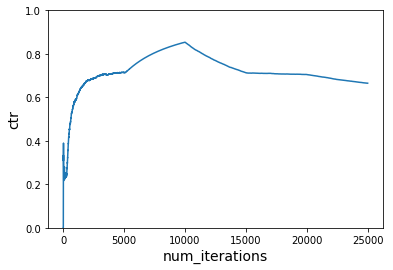

In [90]:
## To ensure reporducibility
random.seed(7)
"""
Adding varying noise to the reward distribution 

Adding various cost functions so that reward function varies over 
the time
We have added 4 new cost functions
------------
Exploartion Algorithm
Bagging Explorer: This exploration rule is based on an ensemble approach. 
It takes in an argument m and trains m different policies.The policies differ by being trained on different random subsets of the data,
with each example going to a subset of the m policies

"""
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --bag 20")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1,get_cost_new2,get_cost_new3,get_cost_new4]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr1 = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)
print('Bagging Explorer')
plot_ctr(total_iterations, ctr1)


Online Cover


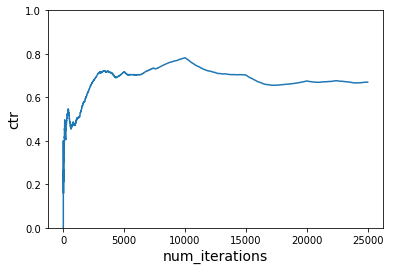

In [91]:
random.seed(7)
"""
Adding varying noise to the reward distribution 

Adding various cost functions so that reward function varies over 
the time
We have added 4 new cost functions
------------
Exploration Algorithm
Online Cover:Like bagging, many different policies are trained, with the number specified as an argument m(here 12) 
Unlike bagging, the training of these policies is explicitly optimized to result in a diverse set of predictions, choosing all the actions which are not already learned to be bad in a given context. 


"""
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --cover 15")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1,get_cost_new2,get_cost_new3,get_cost_new4]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr2 = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)
print('Online Cover')
plot_ctr(total_iterations, ctr2)

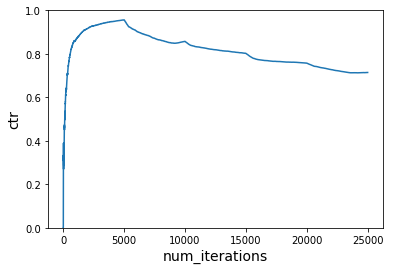

In [71]:
random.seed(7)
"""
Adding varying noise to the reward distribution 

Adding various cost functions so that reward function varies over 
the time
We have added 4 new cost functions
------------
Exploration Algorithm:
Softmax explorer: It uses the policy to not only predict an action but also predict a score indicating the quality of 
each action. A distribution is then created with the probability of action a being is proportional to 
exp(lambda*score(x,a)). Here lambda is a parameter, which leads to uniform exploration for lambda = 0, 
and stops exploring as lambda approaches infinity.
In general, this provides another nice knob for controlled exploration based on the uncertainty in the learned policy.
"""
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --softmax --lambda 10")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1,get_cost_new2,get_cost_new3,get_cost_new4]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr3 = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)
print('Softmax explorer')
plot_ctr(total_iterations, ctr3)

RND Explorer


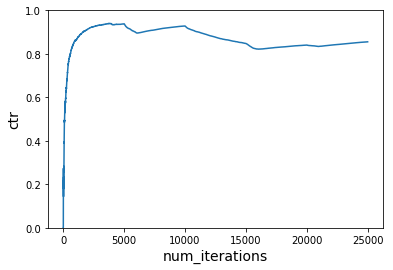

In [93]:
random.seed(7)
"""
Adding varying noise to the reward distribution 

Adding various cost functions so that reward function varies over 
the time
We have added 4 new cost functions
------------
Exploration Algorithm:RND Explorer
Inspired by Random Network Distillation, this explorer constructs an auxiliary prediction problem whose expected target value is zero 
and uses the prediction magnitude to construct a confidence interval. 
In the contextual bandit case this is equivalent to a randomized approximation to the LinUCB bound.
"""
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --rnd 6 --epsilon 0.025 ")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1,get_cost_new2,get_cost_new3, get_cost_new4]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr4 = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)
print('RND Explorer')
plot_ctr(total_iterations, ctr4)

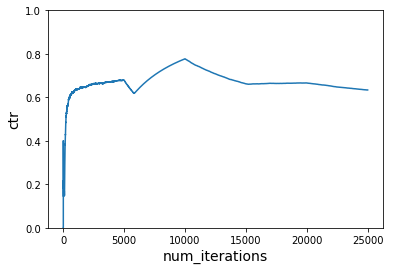

In [94]:
random.seed(7)
"""
Adding varying noise to the reward distribution 

Adding various cost functions so that reward function varies over 
the time
We have added 4 new cost functions
------------
Exploration Algorithm:
Explore First: Same as before, it takes in a parameter tau. On the first tau examples,
we take each of the actions with equal probability. This data is then used to learn a good predictor,
which is used to pick actions for the remaining examples
"""
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --first 100 ")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1,get_cost_new2,get_cost_new3,get_cost_new4]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr5 = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)
plot_ctr(total_iterations, ctr5)

## Comapring the performances of Various exploartion algorithms

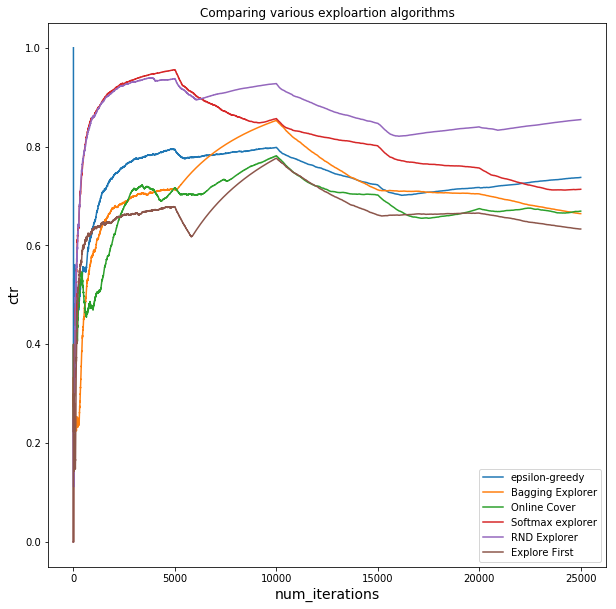

In [88]:
num_iterations=25000

plt.figure(figsize=(10, 10))
plt.title("Comparing various exploartion algorithms")
plt.plot(range(1,num_iterations+1), ctr, label='epsilon-greedy')
plt.plot(range(1,num_iterations+1), ctr1, label= 'Bagging Explorer')
plt.plot(range(1,num_iterations+1), ctr2, label= 'Online Cover')
plt.plot(range(1,num_iterations+1), ctr3, label= 'Softmax explorer')
plt.plot(range(1,num_iterations+1), ctr4, label= 'RND Explorer')
plt.plot(range(1,num_iterations+1), ctr5, label= 'Explore First')
plt.xlabel('num_iterations', fontsize=14)
plt.ylabel('ctr', fontsize=14)
plt.legend(loc="lower right")
#plt.ylim([0,1])


plt.show()

